<a href="https://colab.research.google.com/github/kiyong21c/kaggle/blob/main/20220705_pytorch_tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


##### numpy와 torch로 구현해보는 backward()/no_grad()

In [ ]:
# torch X, Numpy O

import numpy as np

# f = w * x

# f = 2 * x
X = np.array([1, 2, 3, 4], dtype=np.float32)
Y = np.array([2, 4, 6, 8], dtype=np.float32)

w = 0.0 # 시작은 0으로

# model prediction
def forward(x):
    return w * x

# loss = MSE
def loss(y, y_predicted):
    return ((y_predicted-y)**2).mean()

# gradient
# MSE = 1/N * (w*x - y)**2
# dJ/dw = 1/N 2x (w*x - y)
def gradient(x, y, y_predicted):
    return np.dot(2*x, y_predicted-y).mean()

print(f'Prediction before traning: f(5) = {forward(5):.3f}')

# Training
learning_rate = 0.01
n_iters = 10

for epoch in range(n_iters):
    # prediction = fowrard pass
    y_pred = forward(X)

    # loss
    l = loss(Y, y_pred)

    # gradient
    dw = gradient(X, Y, y_pred)

    # update weights
    w -= learning_rate * dw

    if epoch % 1 == 0: # 모든 epoch에 대해
        print(f'epoch {epoch+1}: w ={w:.3f}, loss = {l:.8f}')

print(f'Prediction after traning: f(5) = {forward(5):.3f}')


In [ ]:
# Numpy X pytorch O

import torch

# f = w * x

# f = 2 * x
X = torch.tensor([1, 2, 3, 4], dtype=torch.float32)
Y = torch.tensor([2, 4, 6, 8], dtype=torch.float32)

w = torch.tensor(0.0, dtype=torch.float32, requires_grad=True) # 시작은 0으로

# model prediction
def forward(x):
    return w * x

# loss = MSE
def loss(y, y_predicted):
    return ((y_predicted-y)**2).mean()

# # gradient
# # MSE = 1/N * (w*x - y)**2
# # dJ/dw = 1/N 2x (w*x - y)
# def gradient(x, y, y_predicted):
#     return np.dot(2*x, y_predicted-y).mean()

print(f'Prediction before traning: f(5) = {forward(5):.3f}')

# Training
learning_rate = 0.01
n_iters = 20

for epoch in range(n_iters):
    # prediction = fowrard pass
    y_pred = forward(X)

    # loss
    l = loss(Y, y_pred)

    # gradients = backward pass
    l.backward() # dl/dw
    
    # update weights
    with torch.no_grad():
        # with 구문 안에서 새로 생성된 텐서(파라미터 w)들은 requires_grad=False 상태가 되어, 메모리 사용량을 아껴준다.
        # 파라미터 w의 gradient를 계산하지 않겠다
        w -= learning_rate * w.grad # lr * dl/dw
        # 위에서 새로 정의된 w의 grad가 아닌, 우항의 w.grad(전역변수 w의 grad)만 유효하다

    # zero gradients
    w.grad.zero_()  # w 갱신 후 dl/dw를 초기화(0) 해주자

    if epoch % 1 == 0: # 모든 epoch에 대해
        print(f'epoch {epoch+1}: w ={w:.3f}, loss = {l:.8f}')

print(f'Prediction after traning: f(5) = {forward(5):.3f}')


In [23]:
# 한땀씩

import torch

x = torch.tensor(1.0)
y = torch.tensor(2.0)

# This is the parameter we want to optimize -> requires_grad=True
w = torch.tensor(1.0, requires_grad=True)

# forward pass to compute loss_1
y_predicted = w * x
loss = (y_predicted - y)**2
print('loss :', loss)

# backward pass to compute gradient dLoss/dw
loss.backward()
print(w.grad)   # -2

# learning_rate
lr = 0.01

# update parameter
with torch.no_grad():
    w -= lr * w.grad    # 1 → 1 - (-0.01)*(-2)

print(w)   # 1.02
print(f'before w.grad.zero_() :', w.grad) # -2
w.grad.zero_()
print(f'after w.grad.zero_() :', w.grad)  # 0
print('w :',w) # 1.02 : w.grad가 0가 된것, w는 갱신된 상태

# forward pass to compute loss_2
y_predicted = w * x
loss = (y_predicted - y)**2
print('loss :', loss)

# backward pass to compute gradient dLoss/dw
loss.backward()
print(w.grad)

# 1.순전파 : loss 계산

# 2.역전파 : loss.backward() 하면서 w.grad(=dLoss/dw) 계산됨

# 3.파라미터 업데이트(w.grad계산 꺼줌) : with torch.no_grad(): 

# 4.w.grad(dLoss/dw)를 0으로 초기화 : w.grad.zero_() , 갱신된 w를 통해서 새로운 y_predicted 및 loss가 계산되므로 역전파시 w.grad도 다시 계산되어야 하므로(0안하면 누적됨)

loss : tensor(1., grad_fn=<PowBackward0>)
tensor(-2.)
tensor(1.0200, requires_grad=True)
before w.grad.zero_() : tensor(-2.)
after w.grad.zero_() : tensor(0.)
w : tensor(1.0200, requires_grad=True)
loss : tensor(0.9604, grad_fn=<PowBackward0>)
tensor(-1.9600)


In [44]:
# optimizer 활용

# import torch
import torch.nn as nn

# Linear regression
# f = w * x 

# here : f = 2 * x

# 0) Training samples
X = torch.tensor([1, 2, 3, 4], dtype=torch.float32) # torch.Size([4])
Y = torch.tensor([2, 4, 6, 8], dtype=torch.float32) # torch.Size([4])

# 1) Design Model: Weights to optimize and forward function
w = torch.tensor(0.0, dtype=torch.float32, requires_grad=True)

def forward(x):
    return w * x

print(f'Prediction before training: f(5) = {forward(5).item():.3f}') # 0 : w 초기값이 0이므로

# 2) Define loss and optimizer
learning_rate = 0.01
n_iters = 100

# callable function
loss = nn.MSELoss()

optimizer = torch.optim.SGD([w], lr=learning_rate)  # optimizer가 w, lr과 관련있어 w를 갱신하고, grad를 초기화할 수 있음
optimizer   # optimizer 출력 : 설정된 세팅이 나옴

# 3) Training loop
for epoch in range(n_iters):
    # predict = forward pass
    y_predicted = forward(X)

    # loss
    l = loss(Y, y_predicted)

    # calculate gradients = backward pass
    l.backward()

    with torch.no_grad():   # w 갱신시에는 w.grad계산 꺼주듯이 optimizer 갱신시에도? with torch.no_grad(): 구문 안해도 됨
        # update weights
        optimizer.step()
        # optimizer.grad : 출력 안됨

    # zero the gradients after updating
    optimizer.zero_grad()

    if epoch % 10 == 0:     # 10회 단위로 출력
        print('epoch ', epoch+1, ': w = ', w, ' loss = ', l)


print(f'Prediction after training: f(5) = {forward(5).item():.3f}')

torch.Size([4])
Prediction before training: f(5) = 0.000
epoch  1 : w =  tensor(0.3000, requires_grad=True)  loss =  tensor(30., grad_fn=<MseLossBackward0>)
epoch  11 : w =  tensor(1.6653, requires_grad=True)  loss =  tensor(1.1628, grad_fn=<MseLossBackward0>)
epoch  21 : w =  tensor(1.9341, requires_grad=True)  loss =  tensor(0.0451, grad_fn=<MseLossBackward0>)
epoch  31 : w =  tensor(1.9870, requires_grad=True)  loss =  tensor(0.0017, grad_fn=<MseLossBackward0>)
epoch  41 : w =  tensor(1.9974, requires_grad=True)  loss =  tensor(6.7705e-05, grad_fn=<MseLossBackward0>)
epoch  51 : w =  tensor(1.9995, requires_grad=True)  loss =  tensor(2.6244e-06, grad_fn=<MseLossBackward0>)
epoch  61 : w =  tensor(1.9999, requires_grad=True)  loss =  tensor(1.0176e-07, grad_fn=<MseLossBackward0>)
epoch  71 : w =  tensor(2.0000, requires_grad=True)  loss =  tensor(3.9742e-09, grad_fn=<MseLossBackward0>)
epoch  81 : w =  tensor(2.0000, requires_grad=True)  loss =  tensor(1.4670e-10, grad_fn=<MseLossBac

In [68]:
# model 활용

import torch
import torch.nn as nn

# Linear regression
# f = w * x 

# here : f = 2 * x

# 0) Training samples, watch the shape!
# 모델에 사용될 데이터는 2차원 이어야함
X = torch.tensor([[1], [2], [3], [4]], dtype=torch.float32) 
Y = torch.tensor([[2], [4], [6], [8]], dtype=torch.float32) 

n_samples, n_features = X.shape # torch.Size([4, 1])
print(f'#samples: {n_samples}, #features: {n_features}')

# 0) create a test sample
X_test = torch.tensor([5], dtype=torch.float32) # X_test.shape : torch.Size([1]) 넘파이랑 다른 형식

# 1) Design Model, the model has to implement the forward pass!
# Here we can use a built-in model from PyTorch
input_size = n_features # 1
output_size = n_features # 1

# we can call this model with samples X
model = nn.Linear(input_size, output_size) # 모델생성

'''
class LinearRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearRegression, self).__init__()
        # define diferent layers
        self.lin = nn.Linear(input_dim, output_dim)
    def forward(self, x):
        return self.lin(x)
model = LinearRegression(input_size, output_size)
'''

print(f'Prediction before training: f(5) = {model(X_test).item():.3f}') # 출력할때 마다 다른값
# model(X_test) : tensor([4.1130], grad_fn=<AddBackward0>)
# model(X_test).item() : 4.113


# 2) Define loss and optimizer
learning_rate = 0.01
n_iters = 100

loss = nn.MSELoss() # 모델을 통해 나온값과 실제값의 차이를 MSE 방식으로 처리하겠다
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # 모델의 파라미터(w, b)를 갱신/관리를 SGD 방식으로 하겠다
# list(model.parameters()) : [Parameter containing : tensor([[-0.0085]], requires_grad=True), Parameter containing : tensor([-0.9986], requires_grad=True)]

# 3) Training loop
for epoch in range(n_iters):
    # predict = forward pass with our model
    y_predicted = model(X)

    # loss
    l = loss(Y, y_predicted)

    # calculate gradients = backward pass
    l.backward()

    # update weights
    optimizer.step() # w, b 갱신

    # zero the gradients after updating
    optimizer.zero_grad() # dloss/dw, dloss/db 초기화(0)

    if epoch % 10 == 0:
        [w, b] = model.parameters() # 1)제너레이터를 변수에 나눠서 할당하거나, 2)list화 하거나
        print(f'epoch : {epoch+1},  w = {w[0].item():.3f},  b = {b[0].item():.3f},  loss = {l.item():.3f}')

print(f'Prediction after training: f(5) = {model(X_test).item():.3f}')

#samples: 4, #features: 1
Prediction before training: f(5) = -5.457
epoch : 1,  w = -0.507,  b = -0.388,  loss = 75.157
epoch : 11,  w = 1.482,  b = 0.275,  loss = 1.971
epoch : 21,  w = 1.805,  b = 0.371,  loss = 0.076
epoch : 31,  w = 1.861,  b = 0.377,  loss = 0.026
epoch : 41,  w = 1.873,  b = 0.369,  loss = 0.023
epoch : 51,  w = 1.878,  b = 0.358,  loss = 0.022
epoch : 61,  w = 1.882,  b = 0.348,  loss = 0.020
epoch : 71,  w = 1.885,  b = 0.338,  loss = 0.019
epoch : 81,  w = 1.889,  b = 0.328,  loss = 0.018
epoch : 91,  w = 1.892,  b = 0.318,  loss = 0.017
Prediction after training: f(5) = 9.783


최초 w = -0.9096072912216187 최초 b = 0.6855100393295288
epoch: 10, loss = 4149.9565
epoch: 20, loss = 2922.9468
epoch: 30, loss = 2086.3574
epoch: 40, loss = 1515.8420
epoch: 50, loss = 1126.6963
epoch: 60, loss = 861.2088
epoch: 70, loss = 680.0491
epoch: 80, loss = 556.4081
epoch: 90, loss = 472.0081
epoch: 100, loss = 414.3837
최종 w = 63.70635986328125 최종 b = 0.48071110248565674


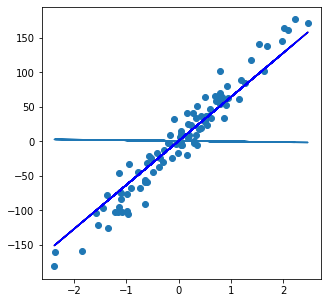

In [98]:
# linear regression

import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
import matplotlib.pyplot as plt

# 0) Prepare data : noise가 들어간 선형 데이터셋 생성
X_numpy, y_numpy = datasets.make_regression(n_samples=100, n_features=1, noise=20, random_state=4)

# Prepare data 시각화
plt.figure(figsize=(5, 5))
plt.scatter(X_numpy, y_numpy)

# cast to float Tensor
X = torch.from_numpy(X_numpy.astype(np.float32))
y = torch.from_numpy(y_numpy.astype(np.float32)) # torch.Size([100])
y = y.view(y.shape[0], 1) # y.view(100, 1) : 1차원의 tensor [100]를 2차원 tensor로 [100, 1]

n_samples, n_features = X.shape

# 1) Model
# Linear model f = wx + b
input_size = n_features
output_size = 1
model = nn.Linear(input_size, output_size)

# 2) Loss and optimizer
learning_rate = 0.01

criterion = nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) 

# 파라미터 확인
w, b = model.parameters()
print('최초 w =',w[0].item(), '최초 b =',b[0].item())
# 최초 파라미터 갱신전 plot
plt.plot(X, w[0].item()*X + b[0].item())

# 3) Training loop
num_epochs = 100
for epoch in range(num_epochs):
    # Forward pass and loss
    y_predicted = model(X)
    loss = criterion(y_predicted, y)
    
    # Backward pass and update
    loss.backward()
    optimizer.step() # optimizer 내부로직에 의해 w, b가 갱신됨

    # zero grad before new step
    optimizer.zero_grad()

    if (epoch+1) % 10 == 0:
        print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')

print('최종 w =',w[0].item(), '최종 b =',b[0].item())
# 최종 파라미터 갱신후 plot(w, b를 이용해 그리는 방법)
plt.plot(X, w[0].item()*X + b[0].item())

# Plot
predicted = model(X).detach().numpy() # detach() : gradient가 전파되지 않는 텐서를 복사(= with torch.no_grad(): 와 같은 개념)

# 최종 파라미터 갱신후 plot(model(X))를 이용해 그리는 방법)
plt.plot(X_numpy, predicted, 'b') # numpy아닌 torch로도 그려짐
plt.show()

In [10]:
# Data Loader

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
import numpy as np
import math

# gradient computation etc. not efficient for whole data set
# -> divide dataset into small batches

'''
# training loop
for epoch in range(num_epochs):
    # loop over all batches
    for i in range(total_batches):
        batch_x, batch_y = ...
'''

# epoch = one forward and backward pass of ALL training samples
# batch_size = number of training samples used in one forward/backward pass
# number of iterations = number of passes, each pass (forward+backward) using [batch_size] number of sampes
# e.g : 100 samples, batch_size=20 -> 100/20=5 iterations for 1 epoch

# --> DataLoader can do the batch computation for us

# Implement a custom Dataset:
# inherit Dataset
# implement __init__ , __getitem__ , and __len__

class WineDataset(Dataset):
    # Dataset 클래스를 상속받으면서, 1)__getitem__, 2)__len__ 재정의(오버라이딩)
    def __init__(self):
        # Initialize data, download, etc.
        # read with numpy or pandas
        xy = np.loadtxt('/content/wine.csv', delimiter=',', dtype=np.float32, skiprows=1)
        self.n_samples = xy.shape[0]

        # here the first column is the class label, the rest are the features
        self.x_data = torch.from_numpy(xy[:, 1:]) # size [n_samples, n_features]
        self.y_data = torch.from_numpy(xy[:, [0]]) # size [n_samples, 1]

    # support indexing such that dataset[i] can be used to get i-th sample
    def __getitem__(self, index):
        # print('__getitem__ 메서드 호출됨')
        return self.x_data[index], self.y_data[index]

    # we can call len(dataset) to return the size
    def __len__(self):
        # print('__len__ 메서드 호출됨')
        return self.n_samples


# create dataset
dataset = WineDataset()

# get first sample and unpack
first_data = dataset[0] # class 매직메소드인 __getitem__이 호출됨
features, labels = first_data
print('-'*10, '첫번째 데이터셋', '-'*10)
print('features :',features, 'labels :',labels)

# Load whole dataset with DataLoader
# shuffle: shuffle data, good for training
# num_workers: faster loading with multiple subprocesses
# !!! IF YOU GET AN ERROR DURING LOADING, SET num_workers TO 0 !!!
train_loader = DataLoader(dataset=dataset,
                          batch_size=4,
                          shuffle=True,
                          num_workers=2)

# convert to an iterator and look at one random sample
dataiter = iter(train_loader) # train_loader를 출력하기위해
data = dataiter.next()
features, labels = data # train_loader를 features, labels로 반환할 수 있음
print('-'*10, 'train_loader(shuffled) sample(random batch)', '-'*10)
print(features, labels) # batch_size에 따라 4개의 데이터셋을 가짐

# Dummy Training loop
num_epochs = 2
total_samples = len(dataset)    # class 매직메소드인 __len__이 호출됨
n_iterations = math.ceil(total_samples/4)   # total_samples(178)/batch_size(4)를 올림
print('전체 데이터 개수 :', total_samples, ', 전체 데이터를 학습하기 위한 batch의 반복횟수 :', n_iterations)
for epoch in range(num_epochs):
    for i, (inputs, labels) in enumerate(train_loader): # i는 iteration이 되겠고, inputs는 피처, labels는 타겟
        



        # here: 178 samples, batch_size = 4, n_iters=178/4=44.5 -> 45 iterations
        # Run your training process
        if (i+1) % 5 == 0:
            print(f'Epoch: {epoch+1}/{num_epochs}, Step {i+1}/{n_iterations}| Inputs {inputs.shape} | Labels {labels.shape}')

# # some famous datasets are available in torchvision.datasets
# # e.g. MNIST, Fashion-MNIST, CIFAR10, COCO

# train_dataset = torchvision.datasets.MNIST(root='./data', 
#                                            train=True, 
#                                            transform=torchvision.transforms.ToTensor(),  
#                                            download=True)

# train_loader = DataLoader(dataset=train_dataset, 
#                                            batch_size=3, 
#                                            shuffle=True)

# # look at one random sample
# dataiter = iter(train_loader)
# data = dataiter.next()
# inputs, targets = data
# print(inputs.shape, targets.shape)

---------- 첫번째 데이터셋 ----------
features : tensor([1.4230e+01, 1.7100e+00, 2.4300e+00, 1.5600e+01, 1.2700e+02, 2.8000e+00,
        3.0600e+00, 2.8000e-01, 2.2900e+00, 5.6400e+00, 1.0400e+00, 3.9200e+00,
        1.0650e+03]) labels : tensor([1.])
---------- train_loader(shuffled) sample(random batch) ----------
tensor([[1.2640e+01, 1.3600e+00, 2.0200e+00, 1.6800e+01, 1.0000e+02, 2.0200e+00,
         1.4100e+00, 5.3000e-01, 6.2000e-01, 5.7500e+00, 9.8000e-01, 1.5900e+00,
         4.5000e+02],
        [1.1760e+01, 2.6800e+00, 2.9200e+00, 2.0000e+01, 1.0300e+02, 1.7500e+00,
         2.0300e+00, 6.0000e-01, 1.0500e+00, 3.8000e+00, 1.2300e+00, 2.5000e+00,
         6.0700e+02],
        [1.3510e+01, 1.8000e+00, 2.6500e+00, 1.9000e+01, 1.1000e+02, 2.3500e+00,
         2.5300e+00, 2.9000e-01, 1.5400e+00, 4.2000e+00, 1.1000e+00, 2.8700e+00,
         1.0950e+03],
        [1.1620e+01, 1.9900e+00, 2.2800e+00, 1.8000e+01, 9.8000e+01, 3.0200e+00,
         2.2600e+00, 1.7000e-01, 1.3500e+00, 3.2500e+00,

In [31]:
# logistic regression
import torch
import torch.nn as nn
import numpy as np
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# 0) Prepare data
bc = datasets.load_breast_cancer()
X, y = bc.data, bc.target   # X.shape : (569, 30), y.shape : (569,)

n_samples, n_features = X.shape

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)

# scale
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test) # X_train으로 훈련하여 X_test에도 적용

X_train = torch.from_numpy(X_train.astype(np.float32))
X_test = torch.from_numpy(X_test.astype(np.float32))
y_train = torch.from_numpy(y_train.astype(np.float32))
y_test = torch.from_numpy(y_test.astype(np.float32))

y_train = y_train.view(y_train.shape[0], 1) # view() : 넘파이의 reshape()과 같다
y_test = y_test.view(y_test.shape[0], 1)

# 1) Model
# Linear model f = wx + b , sigmoid at the end
class Model(nn.Module):
    # nn.Module을 상속받으면서, 1)forward 모듈 재정의(오버라이딩)
    def __init__(self, n_input_features):
        # super(Model, self).__init__()   # # nn.Module 상속
        super().__init__()   # # nn.Module 상속
        self.linear = nn.Linear(n_input_features, 1)

    def forward(self, x):   # nn.Module 클래스에 있는 forward 모듈을 재정의(오버라이딩) 해야함
    # 모델생성 후 self.forward() 하지 않아도 nn.Module의 영향으로 자동으로 호출되는 메서드
        y_pred = torch.sigmoid(self.linear(x))  # torch가 제공하는 sigmoid()
        return y_pred

model = Model(n_features)
# 파라미터 확인
w, b = model.parameters()
print('최초 w =',w[0], '최초 b =',b[0])

# # 2) Loss and optimizer
# num_epochs = 100
# learning_rate = 0.01
# criterion = nn.BCELoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

# # 3) Training loop
# for epoch in range(num_epochs):
#     # Forward pass and loss
#     y_pred = model(X_train)
#     loss = criterion(y_pred, y_train)

#     # Backward pass and update
#     loss.backward()
#     optimizer.step()

#     # zero grad before new step
#     optimizer.zero_grad()

#     if (epoch+1) % 10 == 0:
#         print(f'epoch: {epoch+1}, loss = {loss.item():.4f}')


# with torch.no_grad():
#     y_predicted = model(X_test)
#     y_predicted_cls = y_predicted.round()
#     acc = y_predicted_cls.eq(y_test).sum() / float(y_test.shape[0])
#     print(f'accuracy: {acc.item():.4f}')

최초 w = tensor([ 0.0368, -0.1810,  0.0234, -0.0501,  0.0363,  0.1530, -0.1431, -0.0724,
         0.0855, -0.1682, -0.1096, -0.0773,  0.1293, -0.1557,  0.0532,  0.0395,
        -0.1672,  0.0590,  0.0078, -0.1113,  0.0908, -0.0412, -0.0671, -0.1534,
         0.1595,  0.0268,  0.0896,  0.0304, -0.1641, -0.0221],
       grad_fn=<SelectBackward0>) 최초 b = tensor(-0.1606, grad_fn=<SelectBackward0>)
